In [4]:
%cd NYSE-Temporal-Graph-Construction

[Errno 2] No such file or directory: 'NYSE-Temporal-Graph-Construction'
/home/amintehrani/lfn-projects/NYSE-Temporal-Graph-Construction


/home/amintehrani/lfn-projects/NYSE-Temporal-Graph-Construction/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [5]:
import kagglehub
import kagglehub.datasets
import numpy as np
import pandas as pd
import networkx as nx
from functools import cache
from os.path import join as join_path
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [6]:
CORR_THRESHOLD = 0.232
TRAIN_RATE = 0.8

In [7]:
dataset_path = kagglehub.dataset_download("dgawlik/nyse")

In [8]:
fundamentals_pd = pd.read_csv(join_path(dataset_path,"fundamentals.csv"))
prices_pd = pd.read_csv(join_path(dataset_path, "prices.csv"))
prices_split_adjusted_df = pd.read_csv(join_path(dataset_path, "prices-split-adjusted.csv"))
securities_pd = pd.read_csv(join_path(dataset_path, "securities.csv"))

prices_split_adjusted_df.sort_values(by=['date', 'symbol'], inplace=True)

In [9]:
all_symbols = prices_pd['symbol'].sort_values().unique()

@cache
def symbol_to_int(symbol: str):
    return all_symbols.tolist().index(symbol)

@cache
def int_to_symbol(idx):
    idx = int(idx)
    return all_symbols[idx]

print("Num of symbols:", len(all_symbols))

def get_symbol_by_sector(sector):
    return securities_pd[securities_pd['GICS Sector'] == sector]['Ticker symbol'].to_list()

securities_pd.groupby('GICS Sector')['Ticker symbol'].count()

Num of symbols: 501


GICS Sector
Consumer Discretionary         85
Consumer Staples               37
Energy                         36
Financials                     64
Health Care                    59
Industrials                    69
Information Technology         68
Materials                      25
Real Estate                    29
Telecommunications Services     5
Utilities                      28
Name: Ticker symbol, dtype: int64

In [10]:
prices_split_adjusted_df['date'] = pd.to_datetime(prices_split_adjusted_df['date']).dt.date
dates = prices_split_adjusted_df['date'].sort_values().unique()

@cache
def any_to_date(date):
    if not isinstance(date, pd._libs.tslibs.timestamps.Timestamp):
        date = pd.to_datetime(date).date()
    return date

@cache
def date_to_int(date):
    date = any_to_date(date)
    return dates.tolist().index(date)

@cache
def int_to_date(idx):
    return dates[idx]

print(dates)

[datetime.date(2010, 1, 4) datetime.date(2010, 1, 5)
 datetime.date(2010, 1, 6) ... datetime.date(2016, 12, 28)
 datetime.date(2016, 12, 29) datetime.date(2016, 12, 30)]


In [11]:
data_len = len(prices_split_adjusted_df)
train_rate, test_rate = TRAIN_RATE, 1 - TRAIN_RATE

prices_split_adjusted_df['symbol'] = prices_split_adjusted_df['symbol'].apply(lambda x: symbol_to_int(x))
prices_split_adjusted_df['daily_change'] = (prices_split_adjusted_df['close'] - prices_split_adjusted_df['open']) / prices_split_adjusted_df['open'] * 100 


training_df = prices_split_adjusted_df[:int(train_rate * data_len)]
test_df = prices_split_adjusted_df[int((train_rate) * data_len):]

target_df = training_df


In [12]:
record = target_df.pivot(index='date', columns='symbol', values='daily_change')

correlation_matrix = record.corr()

In [13]:
np.fill_diagonal(correlation_matrix.values, 0)
adj_matrix = correlation_matrix


average_corr = adj_matrix.mean().mean()
print("Average correlation:", average_corr)

adj_matrix = correlation_matrix[correlation_matrix > 0]
# Replace NaN values with 0
adj_matrix = adj_matrix.fillna(0)

g: nx.Graph = nx.from_pandas_adjacency(adj_matrix)

Average correlation: 0.3440724361778559


In [14]:
adj_matrix

symbol,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
symbol,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.312910,0.313391,0.362349,0.373395,0.412581,0.382400,0.507772,0.488402,0.542574,...,0.478223,0.488481,0.566418,0.461568,0.418633,0.376441,0.428346,0.505619,0.506850,0.257444
1,0.312910,0.000000,0.238724,0.212365,0.167983,0.229716,0.203859,0.204787,0.276705,0.286424,...,0.256600,0.202704,0.302059,0.256619,0.262762,0.242383,0.265034,0.257513,0.348068,0.192633
2,0.313391,0.238724,0.000000,0.249704,0.288393,0.242341,0.197099,0.260768,0.287409,0.327769,...,0.284761,0.242890,0.303049,0.282793,0.289914,0.223783,0.355455,0.262150,0.283306,0.157218
3,0.362349,0.212365,0.249704,0.000000,0.173025,0.313280,0.239076,0.361667,0.357510,0.389586,...,0.366853,0.350046,0.330827,0.360507,0.275963,0.350872,0.367416,0.316872,0.290768,0.189781
4,0.373395,0.167983,0.288393,0.173025,0.000000,0.393133,0.387372,0.321089,0.301162,0.341577,...,0.283796,0.290968,0.346580,0.316210,0.298429,0.265990,0.228287,0.382418,0.242512,0.250621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.376441,0.242383,0.223783,0.350872,0.265990,0.337159,0.225608,0.339376,0.381809,0.378662,...,0.348725,0.325044,0.317565,0.307389,0.321764,0.000000,0.316602,0.313328,0.278743,0.170650
497,0.428346,0.265034,0.355455,0.367416,0.228287,0.347178,0.324898,0.388520,0.388988,0.409496,...,0.353203,0.397928,0.397560,0.361388,0.304557,0.316602,0.000000,0.334810,0.361461,0.187047
498,0.505619,0.257513,0.262150,0.316872,0.382418,0.413327,0.428944,0.402085,0.396753,0.411785,...,0.358040,0.442056,0.532977,0.380397,0.344901,0.313328,0.334810,0.000000,0.376008,0.212614


In [15]:
adj_matrix = adj_matrix.copy()

# keep top 10 in each row:
adj_matrix = adj_matrix.apply(lambda row: row.nlargest(10), axis=1)
adj_matrix[symbol_to_int("AAPL")].sort_values(ascending=False)

symbol
202    0.476107
201    0.470817
381    0.452773
0           NaN
1           NaN
         ...   
496         NaN
497         NaN
498         NaN
499         NaN
500         NaN
Name: 3, Length: 497, dtype: float64

In [16]:
wdegrees = {node:degree for node, degree in g.degree(weight='weight')}

get_node_data = lambda node: (sorted(list(map(lambda x: (int_to_symbol(x), round(g.get_edge_data(node, x)['weight'],2)), g.neighbors(node))), key=lambda x: x[1], reverse=True)[:20])
print("Examples (Stock, Weighted Degrees, Sorted Neighbors):")
print("GOOG", *get_node_data(symbol_to_int("GOOG")))
print("AMZN", *get_node_data(symbol_to_int("AMZN")))
print("AAPL", *get_node_data(symbol_to_int("AAPL")))


Examples (Stock, Weighted Degrees, Sorted Neighbors):
GOOG ('GOOGL', 0.99) ('PYPL', 0.55) ('AMZN', 0.51) ('PCLN', 0.5) ('TROW', 0.48) ('AAPL', 0.47) ('AMP', 0.47) ('HON', 0.47) ('ADP', 0.46) ('AMG', 0.46) ('DHR', 0.46) ('IVZ', 0.46) ('PRU', 0.46) ('BEN', 0.45) ('KHC', 0.45) ('QCOM', 0.45) ('SBUX', 0.45) ('ETN', 0.44) ('FB', 0.44) ('IBM', 0.44)
AMZN ('PCLN', 0.57) ('GOOG', 0.51) ('GOOGL', 0.51) ('EXPE', 0.49) ('CRM', 0.48) ('EBAY', 0.47) ('SBUX', 0.47) ('RHT', 0.46) ('TRIP', 0.45) ('WYN', 0.45) ('ADP', 0.44) ('AKAM', 0.44) ('AMP', 0.44) ('DHR', 0.44) ('HON', 0.44) ('NAVI', 0.44) ('SNA', 0.44) ('A', 0.43) ('ADBE', 0.43) ('CMI', 0.43)
AAPL ('PYPL', 0.68) ('GOOGL', 0.48) ('GOOG', 0.47) ('CSCO', 0.45) ('QRVO', 0.45) ('QCOM', 0.44) ('SWKS', 0.44) ('CAT', 0.43) ('KLAC', 0.43) ('CMI', 0.42) ('HON', 0.42) ('MCHP', 0.42) ('AMAT', 0.41) ('F', 0.41) ('FLR', 0.41) ('IBM', 0.41) ('INTC', 0.41) ('KHC', 0.41) ('PCLN', 0.41) ('SBUX', 0.41)


    Ticker symbol                 Security SEC filings  \
3             ACN            Accenture plc     reports   
4            ATVI      Activision Blizzard     reports   
6            ADBE        Adobe Systems Inc     reports   
14           AKAM  Akamai Technologies Inc     reports   
20            ADS    Alliance Data Systems     reports   
..            ...                      ...         ...   
485           WDC          Western Digital     reports   
486            WU         Western Union Co     reports   
496           XRX              Xerox Corp.     reports   
497          XLNX               Xilinx Inc     reports   
500          YHOO               Yahoo Inc.     reports   

                GICS Sector                      GICS Sub Industry  \
3    Information Technology         IT Consulting & Other Services   
4    Information Technology            Home Entertainment Software   
6    Information Technology                   Application Software   
14   Information Techno

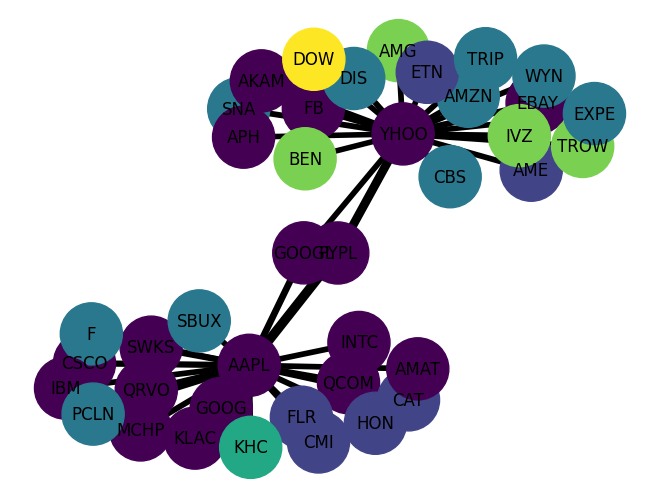

In [17]:
x = {
    # "GOOG": get_node_data(symbol_to_int("GOOG")),
    # "AMZN": get_node_data(symbol_to_int("AMZN")),
    "AAPL": get_node_data(symbol_to_int("AAPL")),
    "YHOO": get_node_data(symbol_to_int("YHOO")),
    # "FB": get_node_data(symbol_to_int("FB")),
}

_sectors = []
def getSector(s):
    sector = securities_pd[securities_pd["Ticker symbol"]==s]['GICS Sector'].to_list()[0]
    print(s, sector)
    try:
        return _sectors.index(sector)
    except:
        _sectors.append(sector)
        return len(_sectors)-1


print(securities_pd[securities_pd["GICS Sector"]=="Information Technology"])


Gx = nx.Graph()

# Add edges to the graph with weights
for node, neighbors in x.items():
    for neighbor, weight in neighbors:
        Gx.add_edge(node, neighbor, weight=weight)


layout = nx.spring_layout(Gx)
nx.draw(Gx, with_labels=True, node_size=2000, node_color=[getSector(s) for s in Gx.nodes() ], width=[weight*10 for (u, v, weight) in Gx.edges(data='weight')])

plt.show()

In [18]:
sectors_graph = nx.Graph()


syms = securities_pd['Ticker symbol'].to_dict()
info_dict = securities_pd[['GICS Sector',"GICS Sub Industry"]].to_dict()

for u_id, u in syms.items():
    for v_id, v in syms.items():
        if u_id == v_id: continue
        w = 0
        u_sec,u_ind = info_dict["GICS Sector"][u_id], info_dict["GICS Sub Industry"][u_id]
        v_sec,v_ind = info_dict["GICS Sector"][v_id], info_dict["GICS Sub Industry"][v_id] 
        
        sectors_graph.add_node(v, sec=v_sec, ind=v_ind)
        sectors_graph.add_node(u, sec=u_sec, ind=u_ind)
        
        if u_sec == v_sec: w+=0.7
        if u_ind == v_ind: w+=0.3
        if w > 0:
            sectors_graph.add_edge(u,v,weight=w)

sectors_graph


In [19]:
# nx.draw(sectors_graph, with_labels=True, node_size=200, width=[weight*10 for (u, v, weight) in sectors_graph.edges(data='weight')])

# plt.show()

nx.write_gexf(sectors_graph, "sectors_graph.gexf")

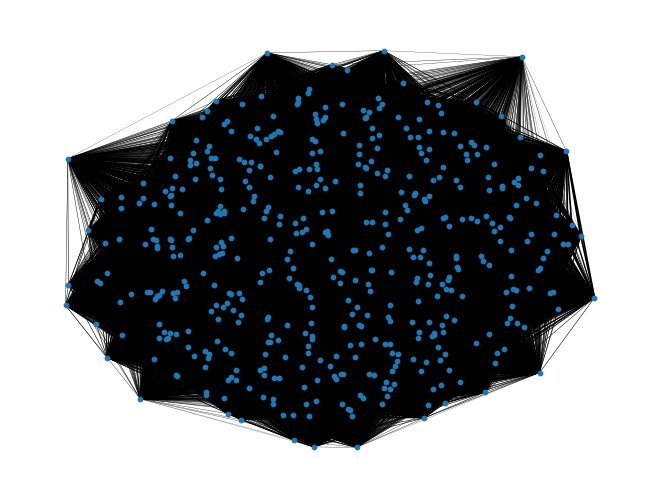

In [20]:
nx.draw(g, with_labels=False, node_size=10, width=[weight*2 for (u, v, weight) in g.edges(data='weight')])
plt.show()
print()

In [21]:
class Predictor:

    def __init__(self, g: nx.Graph, relabel=False):
        if relabel:
            self.g = nx.relabel_nodes(g, dict(map(reversed,enumerate(all_symbols))))
        else:            
            self.g = g

    def _aggregate(self, gc):
        agg_values = {}

        for node_id in gc.nodes:
            neighbors = list(gc.neighbors(node_id))
            sum_values, sum_weights = 0.0, 0.0
            updated = False
            for neighbor in neighbors:
                if 'value' in gc.nodes[neighbor]:
                    v = gc.nodes[neighbor]['value']
                    w = gc.get_edge_data(node_id, neighbor)['weight']
                    sum_values +=  v * w
                    sum_weights += w
                    updated = True
            if updated:
                agg_values[node_id] = sum_values / sum_weights
        
        # Update
        for node_id, value in agg_values.items():
            gc.nodes[node_id]['value'] = value
        return gc
    
    def predict(self, target, neighbors_value):
        res = 0
        sum_weights = 0
        for neighbor, neighbor_value in neighbors_value:
            if isinstance(neighbor, str):
                neighbor = symbol_to_int(neighbor)
            if neighbor not in self.g:
                continue
            w = self.g.get_edge_data(target, neighbor)['weight']
            sum_weights += w
            res += neighbor_value * w
        return res / sum_weights if sum_weights > 0 else None

    def neighbors(self, target):
        if isinstance(target, str):
            target = symbol_to_int(target)
        if target not in self.g:
            return None
        return list(self.g.neighbors(target))

    def __call__(self, node_values: dict, k=1):
        assert k >= 0
        if isinstance(node_values, tuple) or isinstance(node_values, list):
            node_values = dict(node_values)
        
        gc = self.g.copy()
        for source_node, source_value in node_values.items():
            if isinstance(source_node, str):
                source_node = symbol_to_int(source_node)
            
            if source_node not in gc.nodes: # adding unseen nodes without edge
                gc.add_node(source_node)
            gc.nodes[source_node]['value'] = source_value

        # Aggregate
        for _ in range(k):
            gc = self._aggregate(gc)
        
        gc.remove_nodes_from([node_id for node_id in gc.nodes if 'value' not in gc.nodes[node_id]])
        return gc
    
    def available_symbols(self):
        return set(self.g.nodes)


In [29]:
p = Predictor(g)

def evaluate(pred: Predictor, test_dataset: pd.DataFrame = test_df, random_choice_n=None):
    
    i = -1
    for date, date_data in test_dataset.groupby('date'):
        predictions = np.ndarray((len(all_symbols), 2))
        i += 1
        data_symbols = set(date_data['symbol'].unique())
        final_symbols = data_symbols.intersection(pred.available_symbols())

        final_data = date_data[date_data['symbol'].isin(final_symbols)]

        node_values = final_data[['symbol','daily_change']].values.tolist()
        node_values = dict(map(lambda x: (int(x[0]), x[1]), node_values))

        if random_choice_n:
            target_list = np.random.choice(final_symbols, random_choice_n)
        else:
            target_list = final_symbols

        for target in final_symbols:
            actual = node_values[target]

            neighbor_symbols = set(pred.g.neighbors(target)).intersection(final_symbols)
            neighbor_value = [(n, node_values[n]) for n in neighbor_symbols]

            predicted = pred.predict(target, neighbor_value)
            # print(target, predicted)
            if predicted is None or actual is None:
                continue
            predictions[target][0] = predicted
            predictions[target][1] = actual
            
        yield date, predictions
    
df = test_df[test_df['date'].isin(test_df['date'].unique()[:])]


In [33]:

def compute_measures(prediction):
    # discard records where one of the values is nan or inf
    
    var = np.var(prediction[:, 1], axis=0)
    # print(prediction[:, 1])
    se = np.square(prediction[:, 0] - prediction[:, 1])
    # print("var,",var)
    # se[np.isinf(se)] = 0 # find infs in predictions and get it out
    # se[np.isnan(se)] = 0 # find infs in predictions and get it out
    mse = np.mean(se, axis=None)
    r2 = 1 - mse / var
    return var, mse, r2

In [38]:
sectors_predictor = Predictor(sectors_graph, relabel=True)

neighbors = sectors_predictor.neighbors("GOOG")
# print(list(sectors_predictor.g[symbol_to_int("GOOG")])

sectors_predictor.predict(symbol_to_int("GOOG"), [(neighbors[0],1), (neighbors[2],2), (neighbors[3],3)])

predictions = {}
mses, r2s = [], []
for date, prediction in evaluate(sectors_predictor, df):
    
    predictions[date] = (prediction)
    _, mse, r2 = compute_measures(prediction)
    # print(mse, r2)
    # break
    # print(prediction.shape, prediction[:, 1])
    # print(date, compute_measures(prediction))
    mses.append(mse)
    r2s.append(r2)


# print(predictions)
# # # remove NaN:
r2s = [x for x in r2s if not np.isnan(x)]
mses = [x for x in mses if not np.isnan(x)]
print("R2 score:",sum(r2s)/len(r2s))


R2 score: 0.17288915992902282


In [32]:
predictions = {}
mses, r2s = [], []
for date, prediction in evaluate(p, df):
    predictions[date] = (prediction)
    print(prediction)
    break
    _, mse, r2 = compute_measures(prediction)
    # print(prediction.shape, prediction[:, 1])
    # print(date, compute_measures(prediction))
    mses.append(mse)
    r2s.append(r2)

# remove NaN:
r2s = [x for x in r2s if not np.isnan(x)]
mses = [x for x in mses if not np.isnan(x)]


print("R2 score:",sum(r2s)/len(r2s))



[[6.42959057e-310 6.42959057e-310]
 [5.17569558e-310 5.17569558e-310]
 [4.94065646e-324 5.17569558e-310]
 ...
 [8.88066214e-001 1.86548254e+000]
 [8.56864079e-001 1.35382730e+000]
 [9.56169012e-001 1.60735021e+000]]


ZeroDivisionError: division by zero